
# Docente : Josef Rodriguez  
# Masterclass Definitiva: Extracción de Datos con Web Scraping  
## Construcción de Dataset Real con BeautifulSoup  
### Notebook paso a paso (teoría + ejemplos con números + gráficos + industria)

---

## Objetivo

Que el alumno comprenda cómo se construye un dataset real desde cero siguiendo la secuencia:

**Definición real → Fórmula → Detalle → Ejemplo simple → Ejemplo industrial → Importancia → Código + gráfico → Conclusión**



# 1️ Definición Real

Web Scraping es el proceso automatizado de extraer información estructurada desde páginas HTML para convertirla en un dataset utilizable.

---

# 2️ Fórmula Conceptual

URL → HTTP Request → HTML → Parser (BeautifulSoup) → Extracción de campos → DataFrame → Validación

---

# 3️ Detalle (Por qué)

Muchas páginas no ofrecen API.  
Los datos visibles están en el HTML y pueden ser navegados mediante selectores.

---

# 4️ Ejemplo Simple

Una página muestra:

Producto | Precio | Rating  
Libro A | 20 | 4  

Scraping es automatizar la extracción de esa tabla.

---

# 5️ Ejemplo Industrial

- Retail: monitoreo automático de precios.
- Inmobiliaria: extracción de avisos.
- Portales laborales: recopilación de vacantes.

---

# 6️ Importancia

Sin datos confiables, no existe análisis ni modelos sólidos.


In [7]:

# ============================
# IMPORTS
# ============================

# requests:
# Permite realizar solicitudes HTTP (GET, POST, etc.)
# Lo usamos para descargar el HTML de la página web.
import requests


# BeautifulSoup:
# Librería que permite parsear (interpretar) el HTML
# y navegar por sus etiquetas como si fuera un árbol.
from bs4 import BeautifulSoup


# pandas:
# Librería principal para trabajar con estructuras tabulares (DataFrame).
# Aquí almacenaremos los datos scrapeados.
import pandas as pd


# numpy:
# Librería para operaciones numéricas.
# Se usa para cálculos, validaciones y manejo de valores especiales (NaN).
import numpy as np


# matplotlib:
# Librería para generar gráficos.
# La utilizaremos para hacer EDA (distribuciones, barras, etc.)
import matplotlib.pyplot as plt


# re (Regular Expressions):
# Sirve para limpiar texto mediante patrones.
# Por ejemplo, eliminar el símbolo £ del precio.
import re


# time:
# Permite hacer pausas entre requests.
# Es importante para no sobrecargar el servidor.
import time


# random:
# Se usa para generar tiempos de espera aleatorios
# (mejor práctica para evitar patrones de scraping detectables).
import random


In [8]:
# ============================
# CLIENTE HTTP ROBUSTO
# ============================

class HTTPClient:
    """
    Cliente HTTP con:
    - Session reutilizable (mejor performance)
    - User-Agent definido (evita bloqueos básicos)
    - Reintentos con backoff (robustez ante fallos temporales)
    """

    def __init__(self):
        # Una Session reutiliza conexiones TCP → más rápido y estable que requests.get suelto
        self.session = requests.Session()

        # User-Agent: simula un navegador / identifica propósito educativo
        self.session.headers.update({
            "User-Agent": "Masterclass-Scraper/1.0 (educational)"
        })

    def get(self, url: str, retries: int = 3, timeout: int = 20) -> str:
        """
        Descarga el HTML de una URL con reintentos.
        - retries: cuántas veces reintentamos si falla
        - timeout: segundos máximos de espera por request
        Retorna: HTML (string)
        """
        last_err = None

        for attempt in range(retries):
            try:
                # Hacemos el request HTTP GET
                r = self.session.get(url, timeout=timeout)

                # Si el servidor responde 4xx/5xx, dispara excepción
                r.raise_for_status()

                # Si todo salió bien, retornamos el texto HTML
                return r.text

            except Exception as e:
                last_err = e
                print(f"Intento {attempt+1} fallido: {e}")

                # Backoff exponencial: 1.5^attempt (0 → 1, 1 → 1.5, 2 → 2.25, ...)
                # Esto evita golpear el servidor repetidamente si está caído/lento
                time.sleep(1.5 ** attempt)

        # Si llegamos aquí, fallaron todos los intentos
        raise RuntimeError(f"No se pudo obtener la página tras {retries} intentos. Último error: {last_err}")


# Instanciamos el cliente una vez y lo reutilizamos en todo el notebook
client = HTTPClient()

In [ ]:
# ============================
# SCRAPING books.toscrape.com 
# ============================

from urllib.parse import urljoin  # Une URLs correctamente (evita errores al concatenar rutas)

BASE = "https://books.toscrape.com/"  # Dominio base del sitio

# Página inicial estable del catálogo (recomendado para paginación consistente)
START_URL = urljoin(BASE, "catalogue/page-1.html")

# Mapear rating textual (clase HTML) a número
RATING_MAP = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}


def parse_books(html: str):
    """
    Parsear = convertir HTML en un objeto navegable y extraer campos.
    Retorna: lista de diccionarios (registros)
    """
    # BeautifulSoup interpreta el HTML y lo convierte en un árbol de nodos
    soup = BeautifulSoup(html, "html.parser")

    # Cada libro está dentro de un <article class="product_pod">
    books = soup.select("article.product_pod")

    data = []  # aquí guardaremos cada registro (cada libro)

    for b in books:
        # ---- 1) TÍTULO ----
        # Dentro del article, hay un h3 con un <a title="...">
        title = b.h3.a["title"]

        # ---- 2) PRECIO ----
        # El precio está en un span.price_color (ej: "£51.77")
        price_text = b.select_one(".price_color").get_text(strip=True)

        # Regex para quedarnos solo con números y punto: "£51.77" -> "51.77" -> float
        price = float(re.sub(r"[^0-9.]", "", price_text))

        # ---- 3) RATING ----
        # El rating está en <p class="star-rating Three"> (la palabra Three indica el rating)
        rating_classes = b.select_one("p.star-rating")["class"]  # ejemplo: ["star-rating", "Three"]

        # Tomamos la palabra que esté en nuestro mapa
        rating_word = next(x for x in rating_classes if x in RATING_MAP)
        rating = RATING_MAP[rating_word]

        # ---- 4) STOCK / DISPONIBILIDAD ----
        # La disponibilidad está en div.availability (texto: "In stock (22 available)")
        availability_text = b.select_one(".availability").get_text(" ", strip=True)
        in_stock = 1 if "In stock" in availability_text else 0

        # Guardamos el registro completo
        data.append({
            "title": title,
            "price": price,
            "rating": rating,
            "in_stock": in_stock
        })

    return data


def scrape_books(pages: int = 5) -> pd.DataFrame:
    """
    Scrapea N páginas del catálogo.
    - pages: máximo de páginas a recorrer
    Retorna: DataFrame con todos los libros extraídos
    """
    url = START_URL      # empezamos desde la página 1 del catálogo
    all_data = []        # acumulador de registros

    for p in range(pages):
        print(f"Scrapeando página {p+1}: {url}")

        # 1) Descargar HTML
        html = client.get(url)

        # 2) Parsear HTML y extraer registros
        page_data = parse_books(html)
        all_data.extend(page_data)

        # 3) Encontrar botón "next" para la siguiente página
        soup = BeautifulSoup(html, "html.parser")
        next_btn = soup.select_one("li.next > a")

        # 4) Si existe next, construimos la URL correcta con urljoin
        if next_btn:
            next_href = next_btn.get("href")       # ej: "page-2.html"
            url = urljoin(url, next_href)          # une bien aunque sea ruta relativa
        else:
            # Si no hay "next", terminamos
            break

        # 5) Pausa aleatoria para no sobrecargar el servidor (buena práctica)
        time.sleep(random.uniform(0.5, 1.2))

    # Convertimos a DataFrame
    df = pd.DataFrame(all_data)

    return df


# Ejecutar scraping
df_books = scrape_books(pages=5)
df_books.head()

Scrapeando página 1: https://books.toscrape.com/catalogue/page-1.html
Scrapeando página 2: https://books.toscrape.com/catalogue/page-2.html
Scrapeando página 3: https://books.toscrape.com/catalogue/page-3.html
Scrapeando página 4: https://books.toscrape.com/catalogue/page-4.html
Scrapeando página 5: https://books.toscrape.com/catalogue/page-5.html


,title,price,rating,in_stock
0,A Light in the Attic,51.77,3,1
1,Tipping the Velvet,53.74,1,1
2,Soumission,50.10,1,1
3,Sharp Objects,47.82,4,1
4,Sapiens: A Brief History of Humankind,54.23,5,1


#  Cómo “leer” una web para scrapear (HTML y selectores)

## Definición real
Una página web es un documento **HTML**. El navegador lo interpreta como un **árbol** (DOM: Document Object Model).

## Fórmula mental
HTML → DOM (árbol) → Selectores (CSS) → Nodos → Campos → Dataset

## Detalle (por qué)
Scraping NO es “adivinar”. Es:
1) Encontrar el contenedor repetitivo (la “fila”)
2) Dentro de ese contenedor, ubicar los campos (las “columnas”)

## Ejemplo simple
Si una web lista productos, normalmente se repite una estructura:
- un contenedor por producto
- dentro: nombre, precio, rating, stock

## Ejemplo industrial
Un pipeline de precios de competencia:
- Identifica cada tarjeta de producto como “fila”
- Extrae precio, stock y URL
- Valida el schema y persiste a base de datos

## Importancia
Si eliges mal el selector:
- extraes datos incompletos
- extraes basura
- o se rompe el scraper cuando la web cambia

## Mini-guía práctica 
1) Click derecho → “Inspeccionar”
2) Encuentra el bloque que se repite (ej: `article.product_pod`)
3) Prueba un selector CSS:
   - `.price_color` para precio
   - `p.star-rating` para rating
4) Extrae texto con `.get_text(strip=True)`
5) Limpia/convierte a tipos (`float`, `int`)
6) Valida rangos (rating 1–5, precio ≥ 0)

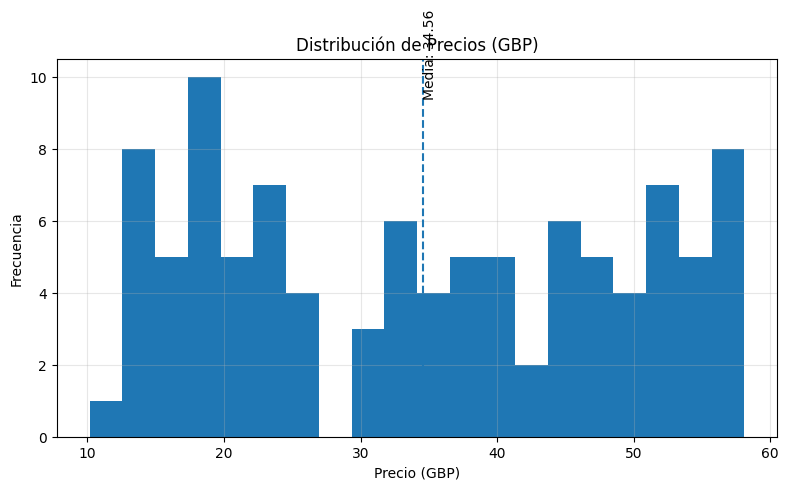

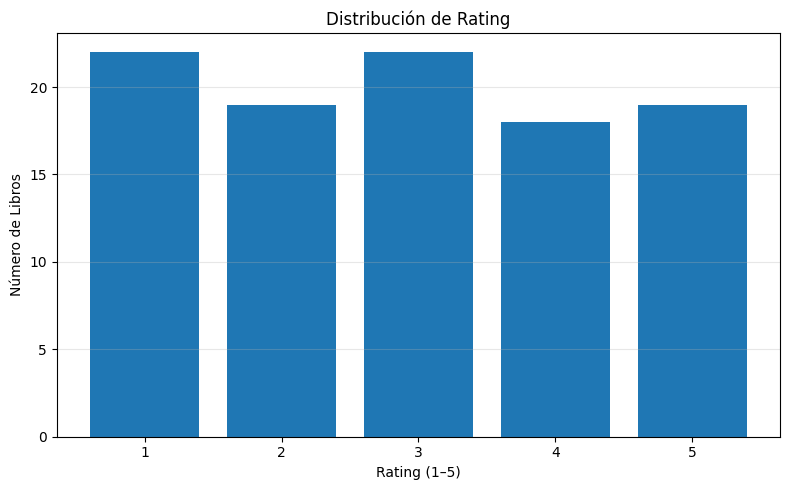

In [ ]:
# ============================
# MINI EDA PROFESIONAL
# ============================

# --- 1️⃣ Distribución de Precios ---

plt.figure(figsize=(8,5))

plt.hist(df_books["price"], bins=20)

plt.title("Distribución de Precios (GBP)", fontsize=12)
plt.xlabel("Precio (GBP)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)

# Línea vertical de la media
mean_price = df_books["price"].mean()
plt.axvline(mean_price, linestyle="--")
plt.text(mean_price, plt.ylim()[1]*0.9,
         f"Media: {mean_price:.2f}",
         rotation=90)

plt.tight_layout()
plt.show()


# --- 2️ Distribución de Rating ---

plt.figure(figsize=(8,5))

rating_counts = df_books["rating"].value_counts().sort_index()

plt.bar(rating_counts.index, rating_counts.values)

plt.title("Distribución de Rating", fontsize=12)
plt.xlabel("Rating (1–5)")
plt.ylabel("Número de Libros")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()



#  Errores comunes en la industria (Web Scraping)

## 1) Scrapear sin revisar estructura / selectores frágiles
**Qué pasa:** tu scraper funciona hoy, pero mañana cambia un `class` y se rompe silenciosamente.  
**Mitigación:**  
- usa selectores más estables (estructura + tags)  
- valida schema (columnas esperadas)  
- agrega tests simples (ej. `assert n_rows > 0`)  

## 2) No manejar timeouts / reintentos
**Qué pasa:** tu pipeline falla por un error temporal de red o del servidor.  
**Mitigación:**  
- timeouts razonables  
- reintentos con backoff exponencial  
- registrar error y continuar (si aplica)  

## 3) No respetar rate limits (sobrecarga)
**Qué pasa:** bloquean tu IP / te tiran 429 / degradan el servicio.  
**Mitigación:**  
- `sleep` aleatorio entre requests  
- limitar páginas por corrida  
- usar caching si repites consultas  

## 4) No usar User-Agent / headers
**Qué pasa:** te bloquean por parecer bot.  
**Mitigación:**  
- define `User-Agent` descriptivo  
- evita headers sospechosos  
- sé transparente (educational)  

## 5) No limpiar tipos (precio como texto, rating como clase)
**Qué pasa:** EDA y modelos fallan o dan resultados incorrectos.  
**Mitigación:**  
- convertir a numérico (precio/rating)  
- normalizar categóricas  
- validar rangos (rating 1–5, precio ≥ 0)  

## 6) Duplicados y registros incompletos
**Qué pasa:** sesgas estadísticas y modelos.  
**Mitigación:**  
- `drop_duplicates()` por clave (ej. título+url)  
- filtrar filas con campos críticos nulos  

## 7) Falta de trazabilidad (no sabes qué se scrapeó)
**Qué pasa:** no puedes auditar de dónde salió el dato.  
**Mitigación:**  
- guardar `source_url`, `page`, `scrape_timestamp`  
- guardar raw (opcional) o logs

---

 **Regla de oro:** si no puedes explicar cómo garantizas calidad, tu scraper no es “industrial”.



# Conclusión

Hemos construido un dataset real desde cero.

Pipeline logrado:

Web → HTML → Extracción → Validación → Dataset listo para análisis

Este es el primer paso profesional antes de cualquier modelo de Machine Learning.
